<a href="https://colab.research.google.com/github/aligtr/ml/blob/master/L2_logreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
# Импорт необходимых модулей 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Базовый анализ данных и построение базовой модели

## загрузка данных

In [157]:
from sklearn.datasets import load_iris

iris_data = load_iris()
feature_names = iris_data['feature_names']
df = pd.DataFrame(iris_data['data'], columns=feature_names)
species_names = iris_data['target_names']
target_idxs = iris_data['target']
df['species'] = species_names[target_idxs]

## анализ данных

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [159]:
df.groupby('species').size()

species
setosa        50
versicolor    50
virginica     50
dtype: int64

Данные имеют 4 признака, все чисненные, по 150 записей каждом без пропусков. Делятся на 3 класса с 50 записями каждого.

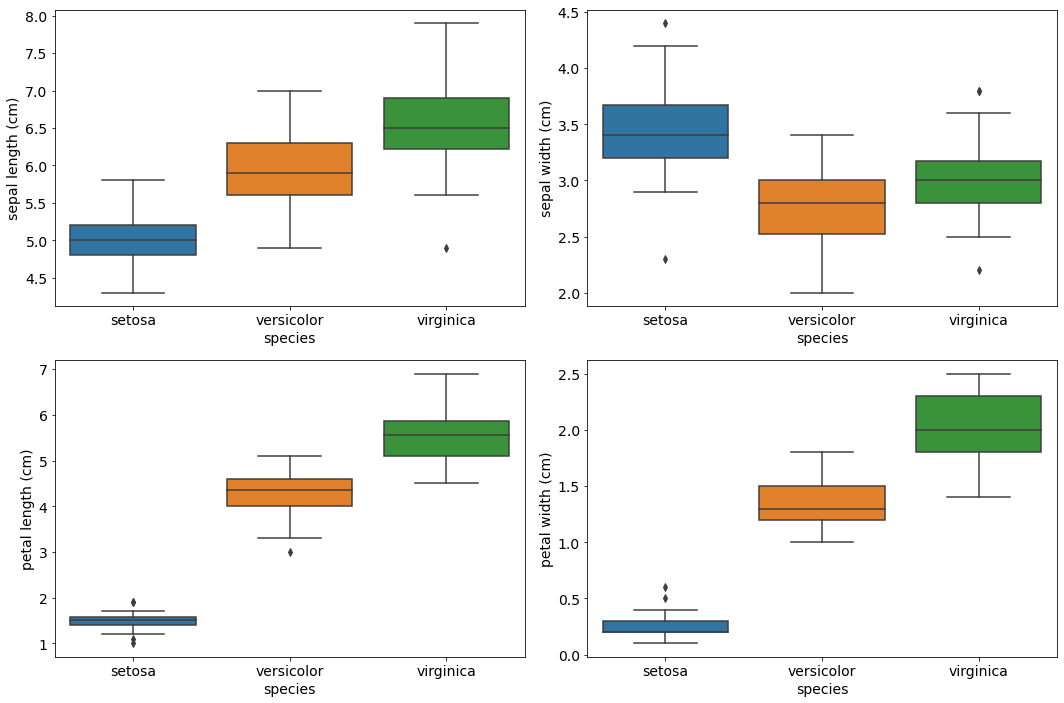

In [160]:
fig, axs = plt.subplots(2, 2)

for i, feat_name in enumerate(feature_names):
    row = i//2
    col = i%2
    sns.boxplot(x = 'species', y = feat_name, data = df, order = species_names, ax = axs[row, col]);
    
fig.tight_layout();

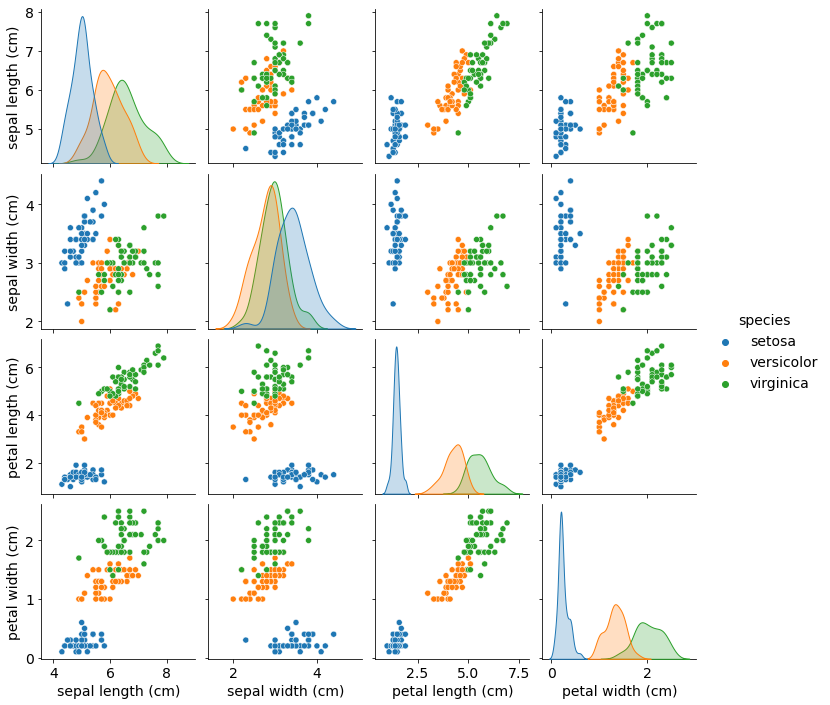

In [161]:
sns.pairplot(df, hue='species')

Очевидно, что класса setosa хорошо отделим от остльных. 
Все признаки сильно корредируют. Однако для разделения групп данных имеет смысл использовать пару признаков petal_width и petal_length.

## создание тренировочной и тестовой выборок

In [162]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO = 0.7

X = df[feature_names]
y = target_idxs

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y
)

## обучение модели

In [163]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=200,
    multi_class='multinomial'
)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## оценка работы модели

In [164]:
sample = X_test.iloc[0]

prediction = logreg.predict([sample])
predict_proba = logreg.predict_proba([sample])
predict_log_proba = logreg.predict_log_proba([sample])

print(f'  Sample:\n{sample}')
print(f'  Prediction proba:\n{predict_proba[0]}')
print(f'  Prediction proba sum:\n{sum(predict_proba[0])}')
print(f'  Prediction log proba:\n{predict_log_proba[0]}')
print(f'  Prediction:\n{prediction}')
print(f'  Prediction name:\n{species_names[prediction]}')

  Sample:
sepal length (cm)    7.3
sepal width (cm)     2.9
petal length (cm)    6.3
petal width (cm)     1.8
Name: 107, dtype: float64
  Prediction proba:
[1.99459949e-06 3.30316900e-02 9.66966315e-01]
  Prediction proba sum:
1.0000000000000002
  Prediction log proba:
[-13.12506729  -3.41028788  -0.03359162]
  Prediction:
[2]
  Prediction name:
['virginica']


In [165]:
from sklearn.metrics import classification_report

y_pred = logreg.predict(X_test)
report = classification_report(
    y_test, y_pred, 
    target_names=species_names
)

print(report)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



In [166]:
from sklearn.model_selection import cross_val_score

X = df[feature_names]
y = target_idxs

# Данная функция используется только для оценки 
#   (она обучает модель внутри, но не возвращает ее)
scores = cross_val_score(
    logreg,     # Модель для оценки
    X,          # Данные для обучения
    y,          # Разметка для обучения
    cv=5,       # Количество фолдов
    scoring='f1_macro'  # Желаемая метрика
)
print(f'Scores: {scores}')
print(f'F1 (macro): {scores.mean(): 0.2f} (+/- {scores.std() * 2: 0.2f})')

Scores: [0.96658312 1.         0.93265993 0.96658312 1.        ]
F1 (macro):  0.97 (+/-  0.05)


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
y_pred_proba=logreg.predict_proba(X_test)
for i in range(3):
  for j in range(3):
    if (i==j):
       continue
    probs = y_pred_proba[:, i]
    mask=(y_test==i)|(y_test==j)
    fpr, tpr, thresholds = roc_curve(y_test[mask], probs[mask])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.show()


# использование StandartScaler

In [168]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# "Обучение" трансформера - определение параметров средних и отклонений
scaler.fit(X_train)

# Стандартизация данных
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg.fit(X_train_scaled , y_train)
y_pred = logreg.predict(X_test_scaled )
report = classification_report(
    y_test, y_pred, 
    target_names=species_names
)

print(report)
scores = cross_val_score(
    logreg,     # Модель для оценки
    scaler.transform(X),          # Данные для обучения
    y,          # Разметка для обучения
    cv=5,       # Количество фолдов
    scoring='f1_macro'  # Желаемая метрика
)
print(f'Scores: {scores}')
print(f'F1 (macro): {scores.mean(): 0.2f} (+/- {scores.std() * 2: 0.2f})')

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.87        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45

Scores: [0.96658312 0.96658312 0.93265993 0.89974937 1.        ]
F1 (macro):  0.95 (+/-  0.07)


Использование стандартизации распределений ухудшило значение метрик.

# Изучение LogisticRegression

In [169]:
logreg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=5,
    multi_class='multinomial'
)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
report = classification_report(
    y_test, y_pred, 
    target_names=species_names
)

print(report)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.50      1.00      0.67        15
   virginica       0.00      0.00      0.00        15

    accuracy                           0.67        45
   macro avg       0.50      0.67      0.56        45
weighted avg       0.50      0.67      0.56        45



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Уменьшение параметра max_iter (максимальное число итераций солвера) ухудшает качество обучения модели. 

In [194]:
logreg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=200,
    multi_class='multinomial'
)

for i, feat_name_i in enumerate(feature_names):
  for j, feat_name_j in enumerate(feature_names):
    if (i<=j):
      continue
    X_scaled=X[[feat_name_i, feat_name_j]]
    scores = cross_val_score(
      logreg,     # Модель для оценки
      X_scaled,          # Данные для обучения
      y,          # Разметка для обучения
      cv=5,       # Количество фолдов
      scoring='f1_macro'  # Желаемая метрика
    )
    print(feat_name_i, feat_name_j)
    print(f'Scores: {scores}')
    print(f'F1 (macro): {scores.mean(): 0.2f} (+/- {scores.std() * 2: 0.2f})')

sepal width (cm) sepal length (cm)
Scores: [0.72222222 0.82949702 0.76608187 0.86666667 0.86807706]
F1 (macro):  0.81 (+/-  0.12)
petal length (cm) sepal length (cm)
Scores: [0.93333333 1.         0.89974937 0.93333333 1.        ]
F1 (macro):  0.95 (+/-  0.08)
petal length (cm) sepal width (cm)
Scores: [0.93333333 1.         0.89974937 0.93333333 1.        ]
F1 (macro):  0.95 (+/-  0.08)
petal width (cm) sepal length (cm)
Scores: [0.93333333 0.96658312 0.93265993 0.93265993 1.        ]
F1 (macro):  0.95 (+/-  0.05)
petal width (cm) sepal width (cm)
Scores: [0.93333333 0.96658312 0.89974937 0.93265993 0.96658312]
F1 (macro):  0.94 (+/-  0.05)
petal width (cm) petal length (cm)
Scores: [0.96658312 0.96658312 0.93265993 0.93333333 1.        ]
F1 (macro):  0.96 (+/-  0.05)


как и предполагалось лучшей парой является petal width (cm) petal length (cm). Однако метрика все равно хуже, чем при использовании всех 4-х признаков.

# метод ближайших соседей

Объект присваивается тому классу, который является наиболее распространённым среди k соседей данного элемента, классы которых уже известны.

In [171]:
from sklearn.neighbors import KNeighborsClassifier

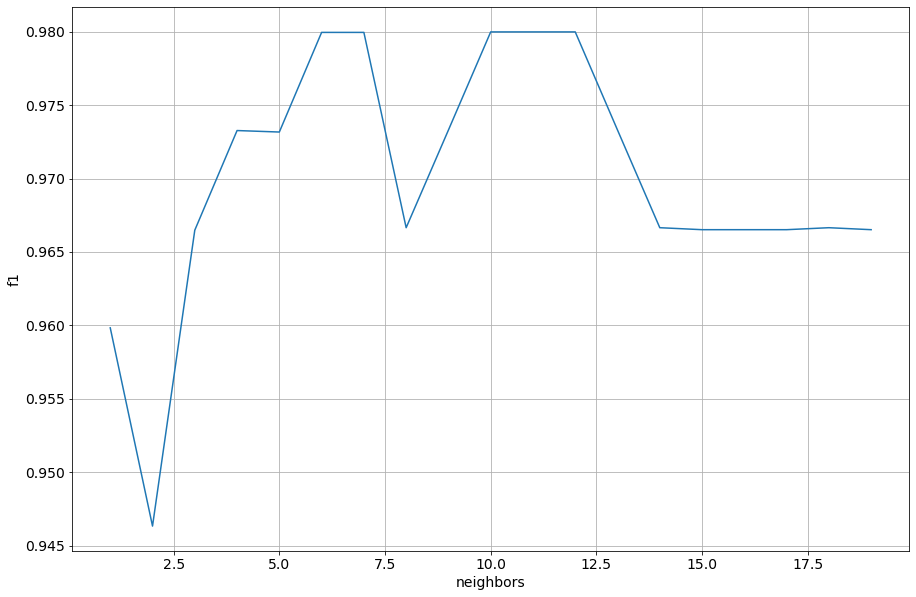

In [192]:
scr=[]
for K_n in range(1,20):
  knn = KNeighborsClassifier(n_neighbors=K_n)
  scores = cross_val_score(
      knn,     # Модель для оценки
      X,          # Данные для обучения
      y,          # Разметка для обучения
      cv=5,       # Количество фолдов
      scoring='f1_macro'  # Желаемая метрика
  )
  scr.append(scores.mean()) 
plt.plot(range(1,20),scr)
plt.grid(True)
plt.ylabel('f1')
plt.xlabel('neighbors')
plt.show()

При использовании всех признаков лучше всего в методе ближайших соседей использвоать 6,7 соседей.
При этом метрика f1 улучшается в сравнении с логистической регрессией.

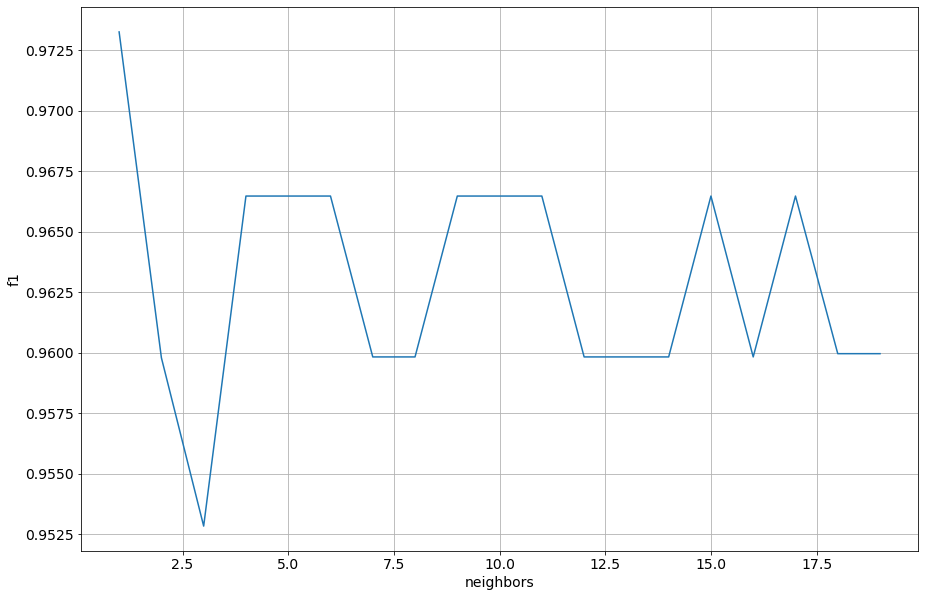

In [200]:
scr=[]
for K_n in range(1,20):
  knn = KNeighborsClassifier(n_neighbors=K_n)
  X_scaled=X[['petal width (cm)','petal length (cm)']]
  scores = cross_val_score(
      knn,     # Модель для оценки
      X_scaled,          # Данные для обучения
      y,          # Разметка для обучения
      cv=5,       # Количество фолдов
      scoring='f1_macro' # Желаемая метрика
  )
  scr.append(scores.mean()) 
plt.plot(range(1,20),scr)
plt.grid(True)
plt.ylabel('f1')
plt.xlabel('neighbors')
plt.show()

При использовании пары признаков результат также улучшается. Наибольшее улучшение при использовании 1 соседа.
Использование других метрик дает тот же результат

# Плоскость решений для лучши пар признаков

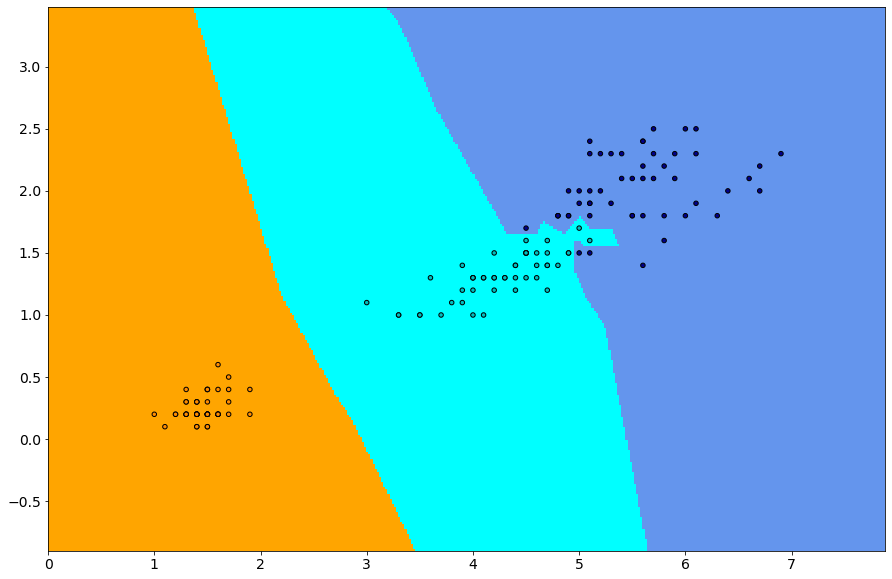

In [216]:
from matplotlib.colors import ListedColormap

h = .02 
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

knn = KNeighborsClassifier(n_neighbors=1)
X_scaled = iris.data[:, 2:4]
knn.fit(X_scaled,y)

x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

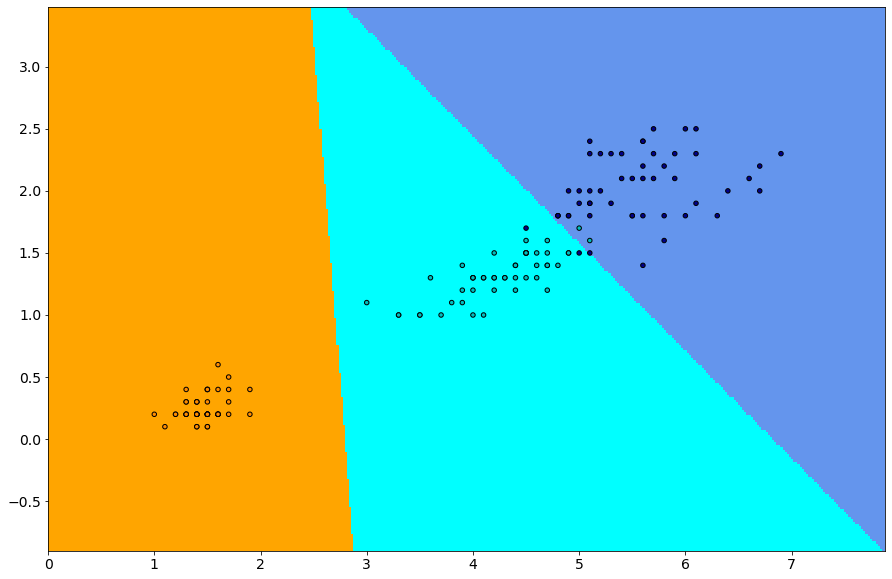

In [214]:
logreg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=200,
    multi_class='multinomial'
)
logreg.fit(X_scaled,y)
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

Судя по графикам, модель ближайших соседей работает лучше, так как меньше точек оказалось не в своей зоне. Также у метода ближайших соседей граница мягче (не является прямой).

# метод опорных векторов (SVM)

идеая метода основано на том, чтобы построить гиперплоскость для наиболее оптимального разделения объектов на классы. При этом в методе считается, что чем больше зазор между гиперплоскостью и объектами, тем лучше.

In [256]:
from sklearn.svm import LinearSVC
TRAIN_RATIO = 0.7

X = df[feature_names]
y = target_idxs

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y
)
svm=LinearSVC(
    tol=1e-10,
    C=10,
    random_state=RANDOM_STATE,
    max_iter=5000
)
svm.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=42, tol=1e-10,
          verbose=0)

In [257]:
scores = cross_val_score(
  svm,     # Модель для оценки
  X_scaled,          # Данные для обучения
  y,          # Разметка для обучения
  cv=5,       # Количество фолдов
  scoring='f1_macro'  # Желаемая метрика
)
print(f'Scores: {scores}')
print(f'F1 (macro): {scores.mean(): 0.2f} (+/- {scores.std() * 2: 0.2f})')

Scores: [1.         0.96658312 0.93265993 0.93265993 1.        ]
F1 (macro):  0.97 (+/-  0.06)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

сущетсвенным оказалось влияние параметра С.
удалось достичь результатов, аналогичных с другими методами.

# Вопросы

* Почему массив весов имеет размер 3х4, а массив смещений - 3 элемента в модели логистической регрессии?
Веса идут для степени принадлежности к каждому классу. Поэтому 3 набора весов. В каждом наборе по одному весу для каждого из 4-х признаков.
* В чем различия методов усреднения статистики `macro`, `micro` и `weighted`?
micro вычисляет с учетом общего количества истинных позитивов, ложных негативов и ложных позитивов
macro вычисляет значение для каждой метрики и возвращает среднее значение без учета пропорции для каждой метрики в наборе данных.
weighted вычисляет значение для каждой метрики и возвращает среднее значение с учетом доли для каждой метрики в наборе данных.
* Что означает `support` в отчете классификации?
Число используемых объектов.
* Продемонстрируйте расчет показателей `recall` и `precision` одного из классов по любой из CM.
* Что происходит при использовании аргумента `stratify` при разделении на выборки? Что будет, если не использовать данный аргумент? 
Этот аргумент указывает, в какой пропорции должны быть классы при разделении. Если не использвоать, то будет произвольно.
* В чем разницах подходов обучения модели линейной регрессии и логистичесой регрессии?
Линейная регрессия служин для поиска взаимосвязи между зависимыми и не зависимыми переменными. Логистичексая регрессия предназначена для классификации.
* На основе чего работает метод KNN?
Объект присваивается тому классу, который является наиболее распространённым среди k соседей данного элемента, классы которых уже известны., также может распростроняться на некоторую область.
* Как влияет количество соседей на работу модели? 
Поидее число соседей должно улучшать работу модели, за счет изучния ближайших уже известных элементов, однако при сильном смешении объектов следует искать наиболее оптимальное значение число соседой.
* В чем отличие кросс-валидации от разделения на выборки обучения/валидации/теста? Для чего применяется выборка обучения? Валидации? А теста?
При кросс-валидации вся выборка делится на заданное число фолдов, по очереди на каждом из них тестируется и на остальных обучается. При постом же разделении на выборки просиходит единоразовое обуечиние на обучающей выборке (модель обучается), валидации (проверяется работоспособность модели для настройки параметров) и тест(конечная проверка/оценка работы модели).

## пример рассчета recall и precision

class0: recall=1.0; precision=1.0
class1: recall=0.9333333333333333; precision=0.875
class2: recall=0.8666666666666667; precision=0.9285714285714286


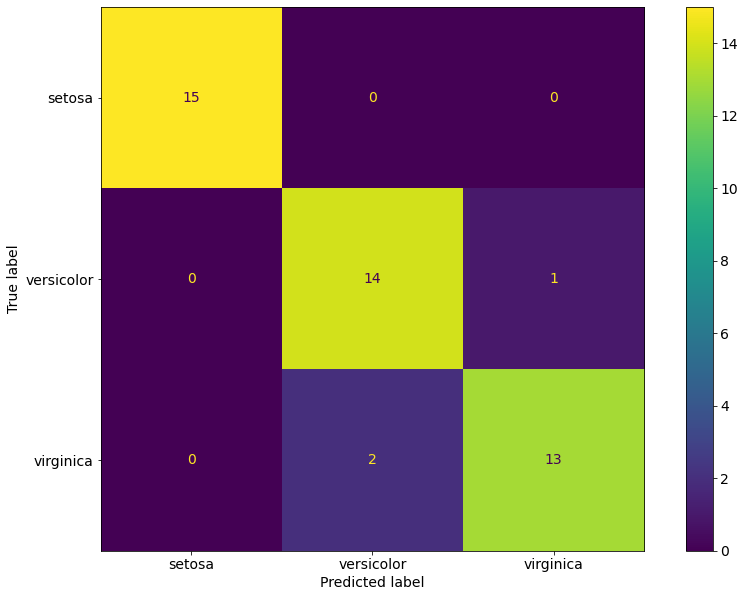

In [227]:
from sklearn.metrics import plot_confusion_matrix
species_names = iris_data['target_names']
logreg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=200,
    multi_class='multinomial'
)
logreg.fit(X_train,y_train)
disp = plot_confusion_matrix(
    logreg, X_test, y_test,
    display_labels=species_names)
for i in range(3):
  recall=disp.confusion_matrix[i,i]/(np.sum(disp.confusion_matrix[i,:]))
  precision=disp.confusion_matrix[i,i]/(np.sum(disp.confusion_matrix[:,i]))
  print(f'class{i}: recall={recall}; precision={precision}')